# Hypothesis Testing 
###### Effect of climate change on crop production 



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import precision_score ,recall_score, f1_score
from sklearn.metrics import accuracy_score

In [2]:
from plotly.offline import iplot, init_notebook_mode,download_plotlyjs
import plotly.graph_objects as go
import plotly.express as px

In [3]:
# This will show the plots as image with out the interactive part. github doesn't show javascript images. that is why I used this.
# To see the interactive plots rerun the notebook , comment this code and rerun the notebook.
# The link for the interactive html of the note book is available on the Readme section of my github. 
import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
#use this code to be able to display all the output in the cell instead of only displaying the out put for the last one. see the next cell.
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

# Load data set:

In [5]:
df_prod=pd.read_csv('FAOSTAT_crop_production.csv') # Total yearly crop production in tonnes by country
df_reg =pd.read_csv('regional_code.csv') #  regions for the country data 
df_crop =pd.read_csv('FAOSTAT_data_main_crop_yield.csv') # crop yield per hectare
df_temp = pd.read_csv('global_temp_change.csv')

In [6]:
df_crop.head()

Domain Code Domain  Area Code         Area  Element Code Element  Item Code  \
0          QC  Crops          2  Afghanistan          5419   Yield         44   
1          QC  Crops          2  Afghanistan          5419   Yield         44   
2          QC  Crops          2  Afghanistan          5419   Yield         44   
3          QC  Crops          2  Afghanistan          5419   Yield         44   
4          QC  Crops          2  Afghanistan          5419   Yield         44   

     Item  Year Code  Year   Unit    Value Flag Flag Description  
0  Barley       1961  1961  hg/ha  10800.0   Fc  Calculated data  
1  Barley       1962  1962  hg/ha  10800.0   Fc  Calculated data  
2  Barley       1963  1963  hg/ha  10800.0   Fc  Calculated data  
3  Barley       1964  1964  hg/ha  10857.0   Fc  Calculated data  
4  Barley       1965  1965  hg/ha  10857.0   Fc  Calculated data

In [7]:
from pandas_profiling import ProfileReport
crop_profile = ProfileReport(df_crop)
crop_profile

In [8]:
df_crop= df_crop.dropna()

In [9]:
df_crop.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag',
       'Flag Description'],
      dtype='object')

In [10]:
#change the column name
df_crop.rename(columns={'Value':'yield'}, inplace=True)

In [11]:
df_crop.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'yield', 'Flag',
       'Flag Description'],
      dtype='object')

We only need the following features from the data. the rest are either constant or irrelevant <br>
[ 'Area Code', 'Area','Item Code', 'Item', 'Year', 'Value']
       

In [12]:
df_crop = df_crop[['Area Code', 'Area','Item Code', 'Item', 'Year', 'yield']]
df_crop.tail()

Area Code      Area  Item Code   Item  Year    yield
37317        181  Zimbabwe         15  Wheat  2014  22094.0
37318        181  Zimbabwe         15  Wheat  2015  20486.0
37319        181  Zimbabwe         15  Wheat  2016  19013.0
37320        181  Zimbabwe         15  Wheat  2017  17542.0
37321        181  Zimbabwe         15  Wheat  2018  20010.0

In [13]:
# def getFiltered(df,col):
#     df_sub=df.query("Item = {}".format(col))
#     df_sub_max = df_sub.groupby(['Year'], as_index = False)['Value'].max()
#     return df_sub_max  

In [14]:
df_crop['Item'].unique()

array(['Barley', 'Maize', 'Millet', 'Rice, paddy', 'Wheat', 'Sorghum'],
      dtype=object)

In [15]:
df_crop['Item'] = df_crop['Item'].str.replace('Rice, paddy', 'Rice')

In [16]:
df_crop['Item'].unique()

array(['Barley', 'Maize', 'Millet', 'Rice', 'Wheat', 'Sorghum'],
      dtype=object)

# Compare the yields in 2010-2014 & 2015-2019

In [17]:
df_crop.head()

Area Code         Area  Item Code    Item  Year    yield
0          2  Afghanistan         44  Barley  1961  10800.0
1          2  Afghanistan         44  Barley  1962  10800.0
2          2  Afghanistan         44  Barley  1963  10800.0
3          2  Afghanistan         44  Barley  1964  10857.0
4          2  Afghanistan         44  Barley  1965  10857.0

In [18]:
#split the data into two groups by year
df_crop_early = df_crop.query("Year in [2010,2011,2012,2013,2014]")
df_crop_late = df_crop.query("Year in [2015,2016,2017,2018,2019]")

In [19]:
# group by crop type to see the difference by crop
df_crop_early_item = df_crop_early.groupby(['Item'], as_index =False)['yield'].sum()
df_crop_late_item = df_crop_late.groupby(['Item'], as_index =False)['yield'].sum()
df_crop_early_item.head()

Item       yield
0   Barley  14945528.0
1    Maize  39375813.0
2   Millet   5575682.0
3     Rice  23271127.0
4  Sorghum  13287493.0

In [20]:
#merge the two groups
df_crop_early_late_item = pd.merge(df_crop_early_item, df_crop_late_item , on='Item',suffixes=('_early', '_late'))
df_crop_early_late_item.head()

Item  yield_early  yield_late
0   Barley   14945528.0  13097659.0
1    Maize   39375813.0  32767738.0
2   Millet    5575682.0   5883755.0
3     Rice   23271127.0  18957323.0
4  Sorghum   13287493.0  11776531.0

In [21]:
#plot the two grops
df_crop_early_late_item.set_index('Item', inplace=True)
df_crop_early_late_item.plot.bar()
plt.ylabel('Yield in tonnes')
plt.xlabel('Crop Type')
plt.title('Yield (2011-2014) vs (2015-2019)')

plt.show()

Text(0, 0.5, 'Yield in tonnes')

Text(0.5, 0, 'Crop Type')

Text(0.5, 1.0, 'Yield (2011-2014) vs (2015-2019)')

In [22]:
#calculate the rate of decrease
df_crop_early_late_item['roi'] = (df_crop_early_late_item['yield_late']-df_crop_early_late_item['yield_early'])/(df_crop_early_late_item['yield_late'])
df_crop_early_late_item['roi'] =df_crop_early_late_item['roi']*100
df_crop_early_late_item.head()

yield_early  yield_late        roi
Item                                       
Barley    14945528.0  13097659.0 -14.108391
Maize     39375813.0  32767738.0 -20.166406
Millet     5575682.0   5883755.0   5.235993
Rice      23271127.0  18957323.0 -22.755344
Sorghum   13287493.0  11776531.0 -12.830281

In [23]:
df_crop_early_late_item.reset_index(inplace =True)

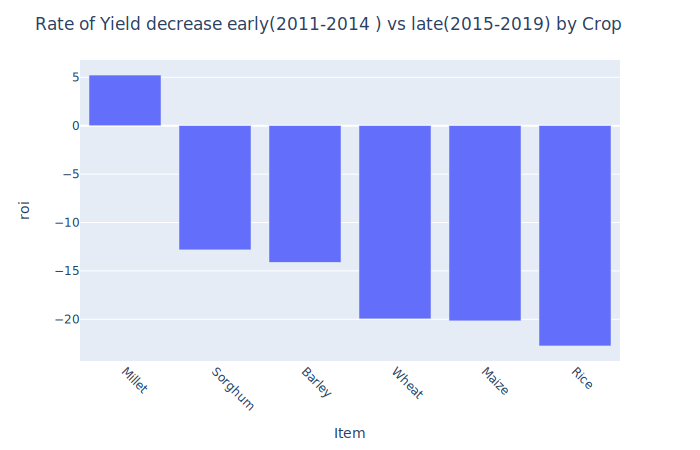

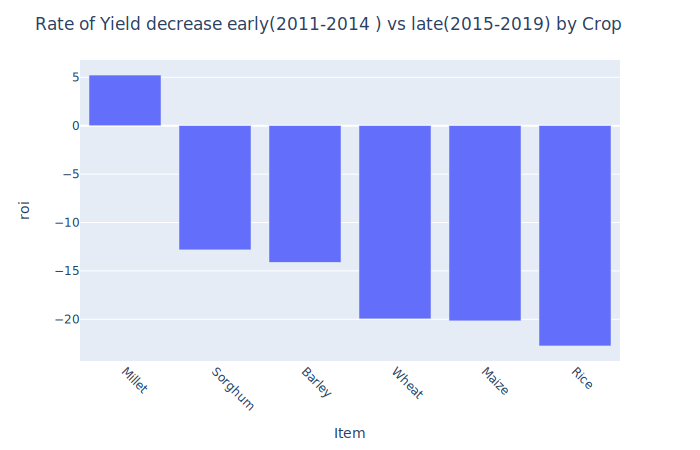

In [24]:
# plot the rate of change 
fig = px.bar(df_crop_early_late_item, x="Item", y= "roi").update_xaxes(categoryorder="max descending")
fig.update_layout(xaxis_tickangle = 45, title = 'Rate of Yield decrease early(2011-2014 ) vs late(2015-2019) by Crop' )
fig.show()

# Crop & Region merged

In order to make analysis by different regions we need the data with regions.

In [25]:
df_reg.head()

Country Group Code Country Group  Country Code  \
0                5100        Africa             4   
1                5100        Africa             7   
2                5100        Africa            53   
3                5100        Africa            20   
4                5100        Africa            24   

                          Country  M49 Code ISO2 Code ISO3 Code  
0                         Algeria      12.0        DZ       DZA  
1                          Angola      24.0        AO       AGO  
2                           Benin     204.0        BJ       BEN  
3                        Botswana      72.0        BW       BWA  
4  British Indian Ocean Territory      86.0        IO       IOT

In [26]:
# we only need the country code and group
df_region = df_reg[['Country Group','Country Code']]
df_region.head()

Country Group  Country Code
0        Africa             4
1        Africa             7
2        Africa            53
3        Africa            20
4        Africa            24

In [27]:
df_crop_reg = pd.merge(df_crop, df_region, how='left', left_on=['Area Code'], right_on=['Country Code'])
df_crop_reg.head()

Area Code         Area  Item Code    Item  Year    yield  \
0          2  Afghanistan         44  Barley  1961  10800.0   
1          2  Afghanistan         44  Barley  1961  10800.0   
2          2  Afghanistan         44  Barley  1961  10800.0   
3          2  Afghanistan         44  Barley  1961  10800.0   
4          2  Afghanistan         44  Barley  1961  10800.0   

                      Country Group  Country Code  
0                              Asia           2.0  
1    Central Asia and Southern Asia           2.0  
2  Land Locked Developing Countries           2.0  
3         Least Developed Countries           2.0  
4              Low income economies           2.0

In [28]:
# df_crop_reg_profile = ProfileReport(df_crop_reg)
# df_crop_reg_profile

In [29]:
df_reg= df_reg.dropna()

In [30]:
df_crop_reg = df_crop_reg.dropna()

In [31]:
#rename the Country Group column
df_crop_reg.rename(columns={"Country Group": "region"} , inplace = True)
df_crop_reg['region'].unique()

array(['Asia', 'Central Asia and Southern Asia',
       'Land Locked Developing Countries', 'Least Developed Countries',
       'Low income economies', 'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries', 'Non-Annex I countries',
       'South Asia (exc India)', 'Southern Asia', 'World', 'Europe',
       'Northern America and Europe', 'Southern Europe',
       'Upper-middle-income economies', 'Africa',
       'North Africa (exc Sudan)', 'Northern Africa',
       'Western Asia and Northern Africa',
       'Lower-middle-income economies', 'Middle Africa',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (including Sudan)',
       'Americas', 'Caribbean', 'High-income economies',
       'Latin America and the Caribbean',
       'Small Island Developing States', 'South America', 'Western Asia',
       'Annex I countries', 'Australia and New Zealand', 'Oceania',
       'OECD', 'European Union', 'Western Europe', 'Eastern Europe',
       'Central America', '

# Compare the yield between 2010-2014 and 2015-2019

In [32]:
df_crop_reg_early = df_crop_reg.query("Year in [2010,2011,2012,2013,2014]")
df_crop_reg_late = df_crop_reg.query("Year in [2015,2016,2017,2018,2019]")
df_crop_reg_early_r = df_crop_reg_early.groupby(['region'], as_index =False)['yield'].sum()
df_crop_reg_late_r = df_crop_reg_late.groupby(['region'], as_index =False)['yield'].sum()
df_crop_reg_early_r.head()
df_crop_reg_early_late_r = pd.merge(df_crop_reg_early_r, df_crop_reg_late_r , on='region',suffixes=('_early', '_late'))
#df_crop_reg_early_late_r.set_index('region', inplace=True)
df_crop_reg_early_late_r.head()


region       yield
0                     Africa  19369713.0
1                   Americas  20367009.0
2          Annex I countries  39990228.0
3                       Asia  36014087.0
4  Australia and New Zealand   2507117.0

region  yield_early  yield_late
0                     Africa   19369713.0  15745788.0
1                   Americas   20367009.0  17045670.0
2          Annex I countries   39990228.0  33843079.0
3                       Asia   36014087.0  31583382.0
4  Australia and New Zealand    2507117.0   2123360.0

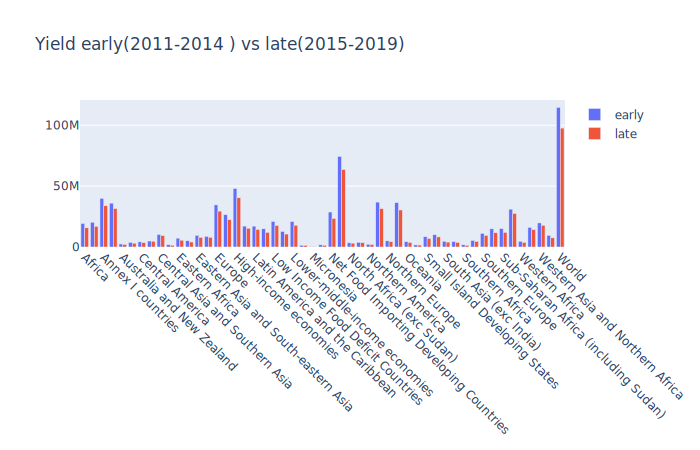

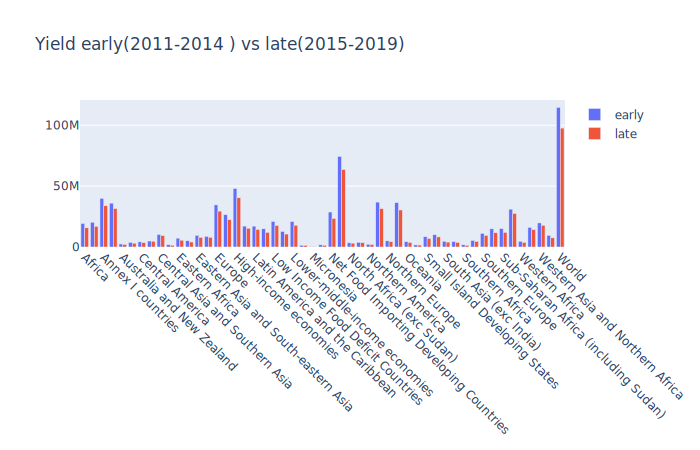

In [33]:
import plotly.graph_objects as go
regions=df_crop_reg_early_late_r['region']
early = df_crop_reg_early_late_r['yield_early']
late =df_crop_reg_early_late_r['yield_late']
fig = go.Figure(data=[
    go.Bar(name='early', x=regions, y=early),
    go.Bar(name='late', x=regions, y=late)
])
# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle = 45, title = 'Yield  early(2011-2014 ) vs late(2015-2019)' )
fig.show()

In [34]:
# calculate the rate of decrease
df_crop_reg_early_late_r['roi'] = (df_crop_reg_early_late_r['yield_late']-df_crop_reg_early_late_r['yield_early'])/(df_crop_reg_early_late_r['yield_late'])
df_crop_reg_early_late_r['roi'] =df_crop_reg_early_late_r['roi']*100
df_crop_reg_early_late_r.head()

region  yield_early  yield_late        roi
0                     Africa   19369713.0  15745788.0 -23.015203
1                   Americas   20367009.0  17045670.0 -19.484943
2          Annex I countries   39990228.0  33843079.0 -18.163681
3                       Asia   36014087.0  31583382.0 -14.028596
4  Australia and New Zealand    2507117.0   2123360.0 -18.073101

In [35]:
df_crop_reg_early_late_r.nlargest(10,['roi'])

region  yield_early  yield_late  \
7                                  Central Asia    4894283.0   4758287.0   
23                                    Melanesia    1429922.0   1352055.0   
35  Oceania excluding Australia and New Zealand    1705145.0   1581211.0   
13                               Eastern Europe    8693174.0   8004663.0   
29                              Northern Africa    3846947.0   3529905.0   
28                     North Africa (exc Sudan)    3461637.0   3152066.0   
8                Central Asia and Southern Asia   10307088.0   9366201.0   
48             Western Asia and Northern Africa   19782757.0  17794846.0   
17             Land Locked Developing Countries   17159184.0  15428735.0   
30                             Northern America    2284215.0   2038444.0   

          roi  
7   -2.858087  
23  -5.759159  
35  -7.837917  
13  -8.601374  
29  -8.981601  
28  -9.821209  
8  -10.045556  
48 -11.171274  
17 -11.215754  
30 -12.056794

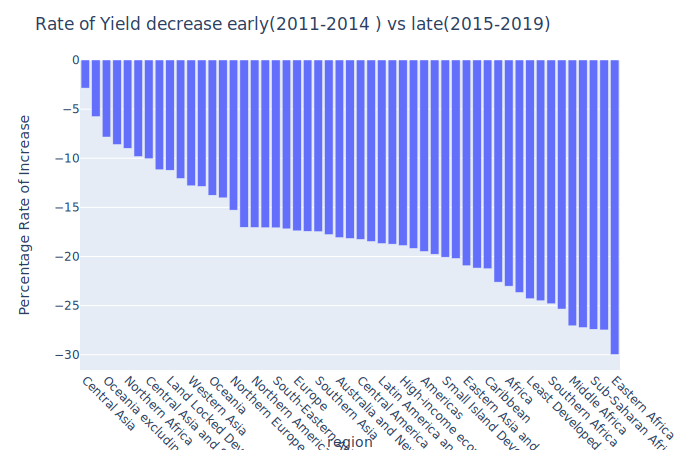

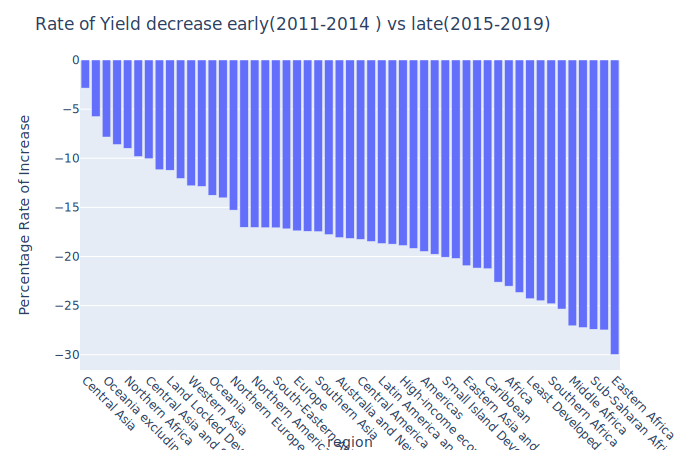

In [36]:
fig = px.bar(df_crop_reg_early_late_r, x="region", y= "roi").update_xaxes(categoryorder="max descending")
fig.update_layout(barmode='group', xaxis_tickangle = 45, 
                  title = 'Rate of Yield decrease early(2011-2014 ) vs late(2015-2019)',
yaxis_title="Percentage Rate of Increase")                  
fig.show()

# Temprature

In [37]:
df_temp.head()

Domain Code              Domain  Area Code         Area  Element Code  \
0          ET  Temperature change          2  Afghanistan          7271   
1          ET  Temperature change          2  Afghanistan          7271   
2          ET  Temperature change          2  Afghanistan          7271   
3          ET  Temperature change          2  Afghanistan          7271   
4          ET  Temperature change          2  Afghanistan          7271   

              Element  Months Code   Months  Year Code  Year Unit  Value Flag  \
0  Temperature change         7001  January       1961  1961   °C  0.777   Fc   
1  Temperature change         7001  January       1962  1962   °C  0.062   Fc   
2  Temperature change         7001  January       1963  1963   °C  2.744   Fc   
3  Temperature change         7001  January       1964  1964   °C -5.232   Fc   
4  Temperature change         7001  January       1965  1965   °C  1.868   Fc   

  Flag Description  
0  Calculated data  
1  Calculated data  
2  Calculated data  
3  Calculated data  
4  Calculated data

In [38]:
df_temp.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Months Code', 'Months', 'Year Code', 'Year', 'Unit', 'Value', 'Flag',
       'Flag Description'],
      dtype='object')

In [39]:
df_temp.rename(columns={'Value':'temperature'}, inplace =True)

In [40]:
df_temp.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Months Code', 'Months', 'Year Code', 'Year', 'Unit', 'temperature',
       'Flag', 'Flag Description'],
      dtype='object')

We only need the following features from the data. the rest are either constant or irrelevant <br>
[ 'Area Code', 'Area','Months Code', 'Months', 'Year', 'Value']

In [41]:
df_temp = df_temp[[ 'Area Code', 'Area','Months Code', 'Months', 'Year', 'temperature']]
df_temp.head()

Area Code         Area  Months Code   Months  Year  temperature
0          2  Afghanistan         7001  January  1961        0.777
1          2  Afghanistan         7001  January  1962        0.062
2          2  Afghanistan         7001  January  1963        2.744
3          2  Afghanistan         7001  January  1964       -5.232
4          2  Afghanistan         7001  January  1965        1.868

In [42]:
df_temp.isna().sum()

Area Code         0
Area              0
Months Code       0
Months            0
Year              0
temperature    7685
dtype: int64

In [43]:
df_temp=df_temp.dropna()

In [44]:
df_temp_metro = df_temp.query("Months == 'Meteorological year'") 
df_temp_metro.head()

Area Code         Area  Months Code               Months  Year  \
944          2  Afghanistan         7020  Meteorological year  1961   
945          2  Afghanistan         7020  Meteorological year  1962   
946          2  Afghanistan         7020  Meteorological year  1963   
947          2  Afghanistan         7020  Meteorological year  1964   
948          2  Afghanistan         7020  Meteorological year  1965   

     temperature  
944       -0.080  
945       -0.120  
946        0.882  
947       -0.727  
948       -0.200

In [45]:
df_temp_metro_2016 =df_temp_metro.query("Year == '2016' ")
df_temp_metro_2016.head()

Area Code            Area  Months Code               Months  Year  \
999           2     Afghanistan         7020  Meteorological year  2016   
2002          3         Albania         7020  Meteorological year  2016   
3005          4         Algeria         7020  Meteorological year  2016   
4008          5  American Samoa         7020  Meteorological year  2016   
5011          6         Andorra         7020  Meteorological year  2016   

      temperature  
999         1.473  
2002        1.697  
3005        1.866  
4008        1.648  
5011        1.917

# Merging the Temperature  & crop data

In [46]:
df_crop_reg_sorted=df_crop_reg.sort_values(by=['Year'])
df_temp_sorted=df_temp.sort_values(by=['Year'])

In [47]:
df_crop_temp  = pd.merge_asof(df_temp_sorted, df_crop_reg_sorted,
              on='Year',
              by='Area')

df_crop_temp.head()

Area Code_x             Area  Months Code   Months  Year  temperature  \
0            2      Afghanistan         7001  January  1961        0.777   
1           25  Solomon Islands         7005      May  1961        0.233   
2          259  Channel Islands         7005      May  1961        0.227   
3           25  Solomon Islands         7006     June  1961        0.373   
4          259  Channel Islands         7004    April  1961        2.249   

   Area Code_y  Item Code    Item    yield         region  Country Code  
0          2.0       44.0  Barley  10800.0  Southern Asia           2.0  
1         25.0       27.0    Rice  17391.0          World          25.0  
2          NaN        NaN     NaN      NaN            NaN           NaN  
3         25.0       27.0    Rice  17391.0          World          25.0  
4          NaN        NaN     NaN      NaN            NaN           NaN

In [48]:
df_crop_reg.head()

Area Code         Area  Item Code    Item  Year    yield  \
0          2  Afghanistan         44  Barley  1961  10800.0   
1          2  Afghanistan         44  Barley  1961  10800.0   
2          2  Afghanistan         44  Barley  1961  10800.0   
3          2  Afghanistan         44  Barley  1961  10800.0   
4          2  Afghanistan         44  Barley  1961  10800.0   

                             region  Country Code  
0                              Asia           2.0  
1    Central Asia and Southern Asia           2.0  
2  Land Locked Developing Countries           2.0  
3         Least Developed Countries           2.0  
4              Low income economies           2.0

In [49]:
df_crop_temp.isna().sum()

Area Code_x         0
Area                0
Months Code         0
Months              0
Year                0
temperature         0
Area Code_y     48500
Item Code       48500
Item            48500
yield           48500
region          48500
Country Code    48500
dtype: int64

In [50]:
df_crop_temp= df_crop_temp.dropna()

In [51]:
df_crop_temp.shape

(169677, 12)

In [52]:
df_crop_temp.isna().sum()

Area Code_x     0
Area            0
Months Code     0
Months          0
Year            0
temperature     0
Area Code_y     0
Item Code       0
Item            0
yield           0
region          0
Country Code    0
dtype: int64

In [53]:
# query by name of the crop
product =df_crop_temp['Item'].unique()
for prod in product:
     globals()[prod] = df_crop_temp.loc[df_crop_temp['Item'] == prod]

In [54]:
Maize_max =Maize.groupby(['Year'], as_index = False)['yield'].max()
Wheat_max =Wheat.groupby(['Year'], as_index = False)['yield'].max()
Rice_max =Rice.groupby(['Year'], as_index = False)['yield'].max()

In [55]:
# df_crop_temp.rename(columns={"Country Group": "region"} , inplace = True)
# df_crop_temp['region'].unique()

In [56]:
df_crop_temp['region'] = df_crop_temp['region'].str.replace(' ','_')
df_crop_temp['region'].unique()

array(['Southern_Asia', 'World', 'Land_Locked_Developing_Countries',
       'Americas', 'Sub-Saharan_Africa_(including_Sudan)',
       'Net_Food_Importing_Developing_Countries', 'Sub-Saharan_Africa',
       'Non-Annex_I_countries', 'Africa', 'Least_Developed_Countries',
       'Asia', 'Eastern_Asia_and_South-eastern_Asia',
       'Low_Income_Food_Deficit_Countries', 'Eastern_Africa',
       'Latin_America_and_the_Caribbean', 'Annex_I_countries', 'OECD',
       'High-income_economies', 'Europe', 'Lower-middle-income_economies',
       'South_America', 'Western_Europe',
       'Small_Island_Developing_States', 'Western_Africa',
       'Northern_America_and_Europe', 'Western_Asia_and_Northern_Africa',
       'Upper-middle-income_economies', 'Caribbean',
       'Oceania_excluding_Australia_and_New_Zealand', 'Northern_Africa',
       'Central_America', 'Northern_Europe', 'Oceania',
       'Central_Asia_and_Southern_Asia', 'Western_Asia',
       'Southern_Europe', 'Southern_Africa', 'Europea

In [57]:
df_crop_temp['region'] = df_crop_temp['region'].str.replace('-','_')
df_crop_temp['region'].unique()

array(['Southern_Asia', 'World', 'Land_Locked_Developing_Countries',
       'Americas', 'Sub_Saharan_Africa_(including_Sudan)',
       'Net_Food_Importing_Developing_Countries', 'Sub_Saharan_Africa',
       'Non_Annex_I_countries', 'Africa', 'Least_Developed_Countries',
       'Asia', 'Eastern_Asia_and_South_eastern_Asia',
       'Low_Income_Food_Deficit_Countries', 'Eastern_Africa',
       'Latin_America_and_the_Caribbean', 'Annex_I_countries', 'OECD',
       'High_income_economies', 'Europe', 'Lower_middle_income_economies',
       'South_America', 'Western_Europe',
       'Small_Island_Developing_States', 'Western_Africa',
       'Northern_America_and_Europe', 'Western_Asia_and_Northern_Africa',
       'Upper_middle_income_economies', 'Caribbean',
       'Oceania_excluding_Australia_and_New_Zealand', 'Northern_Africa',
       'Central_America', 'Northern_Europe', 'Oceania',
       'Central_Asia_and_Southern_Asia', 'Western_Asia',
       'Southern_Europe', 'Southern_Africa', 'Europea

In [89]:
regions =df_crop_temp['region'].unique()
for reg in regions:
     globals()[reg] = df_crop_temp.loc[df_crop_temp['region'] == reg]

In [59]:
regions

array(['Southern_Asia', 'World', 'Land_Locked_Developing_Countries',
       'Americas', 'Sub_Saharan_Africa_(including_Sudan)',
       'Net_Food_Importing_Developing_Countries', 'Sub_Saharan_Africa',
       'Non_Annex_I_countries', 'Africa', 'Least_Developed_Countries',
       'Asia', 'Eastern_Asia_and_South_eastern_Asia',
       'Low_Income_Food_Deficit_Countries', 'Eastern_Africa',
       'Latin_America_and_the_Caribbean', 'Annex_I_countries', 'OECD',
       'High_income_economies', 'Europe', 'Lower_middle_income_economies',
       'South_America', 'Western_Europe',
       'Small_Island_Developing_States', 'Western_Africa',
       'Northern_America_and_Europe', 'Western_Asia_and_Northern_Africa',
       'Upper_middle_income_economies', 'Caribbean',
       'Oceania_excluding_Australia_and_New_Zealand', 'Northern_Africa',
       'Central_America', 'Northern_Europe', 'Oceania',
       'Central_Asia_and_Southern_Asia', 'Western_Asia',
       'Southern_Europe', 'Southern_Africa', 'Europea

In [60]:
Africa.head()

Area Code_x        Area  Months Code     Months  Year  temperature  \
215           35  Cabo Verde         7011   November  1961       -0.542   
217           35  Cabo Verde         7010    October  1961       -0.184   
219           35  Cabo Verde         7009  September  1961       -0.416   
221           35  Cabo Verde         7008     August  1961        0.117   
223           35  Cabo Verde         7007       July  1961        0.012   

     Area Code_y  Item Code   Item   yield  region  Country Code  
215         35.0       56.0  Maize  6500.0  Africa          35.0  
217         35.0       56.0  Maize  6500.0  Africa          35.0  
219         35.0       56.0  Maize  6500.0  Africa          35.0  
221         35.0       56.0  Maize  6500.0  Africa          35.0  
223         35.0       56.0  Maize  6500.0  Africa          35.0

In [61]:
Africa_maize = Africa.query("Item=='Maize'")
Africa_maize_max = Africa_maize.groupby(['Year'], as_index=False)['yield'].max()
Africa_rice = Africa.query("Item=='Rice'")
Africa_rice_max = Africa_rice.groupby(['Year'], as_index=False)['yield'].max()
Africa_wheat = Africa.query("Item=='Wheat'")
Africa_wheat_max = Africa_wheat.groupby(['Year'], as_index=False)['yield'].max()

In [62]:
df_crop_temp['temp']= df_crop_temp.temperature.apply(lambda x : 'low' if (x>=0 and x<=2) else 'high')     
df_crop_temp.head()

Area Code_x             Area  Months Code   Months  Year  temperature  \
0            2      Afghanistan         7001  January  1961        0.777   
1           25  Solomon Islands         7005      May  1961        0.233   
3           25  Solomon Islands         7006     June  1961        0.373   
5           25  Solomon Islands         7007     July  1961        0.462   
7           25  Solomon Islands         7008   August  1961        0.211   

   Area Code_y  Item Code    Item    yield         region  Country Code temp  
0          2.0       44.0  Barley  10800.0  Southern_Asia           2.0  low  
1         25.0       27.0    Rice  17391.0          World          25.0  low  
3         25.0       27.0    Rice  17391.0          World          25.0  low  
5         25.0       27.0    Rice  17391.0          World          25.0  low  
7         25.0       27.0    Rice  17391.0          World          25.0  low

In [63]:
df_crop_temp_high = df_crop_temp.query("temp=='high'")
df_crop_temp_low = df_crop_temp.query("temp=='low'")
df_crop_temp_high_i = df_crop_temp_high.groupby(['Item'], as_index =False)['yield'].sum()
df_crop_temp_low_i = df_crop_temp_low.groupby(['Item'], as_index =False)['yield'].sum()
df_crop_temp_low_i.head()
df_crop_temp_high_low_i = pd.merge(df_crop_temp_high_i, df_crop_temp_low_i , on='Item',suffixes=('_high', '_low'))
#df_crop_reg_early_late_r.set_index('region', inplace=True)
df_crop_temp_high_low_i.head()


Item        yield
0   Barley  343775426.0
1    Maize  990381922.0
2   Millet   93654532.0
3     Rice  643629657.0
4  Sorghum  265219123.0

Item   yield_high    yield_low
0   Barley  264857495.0  343775426.0
1    Maize  450261303.0  990381922.0
2   Millet   55939892.0   93654532.0
3     Rice  264996551.0  643629657.0
4  Sorghum  113150759.0  265219123.0

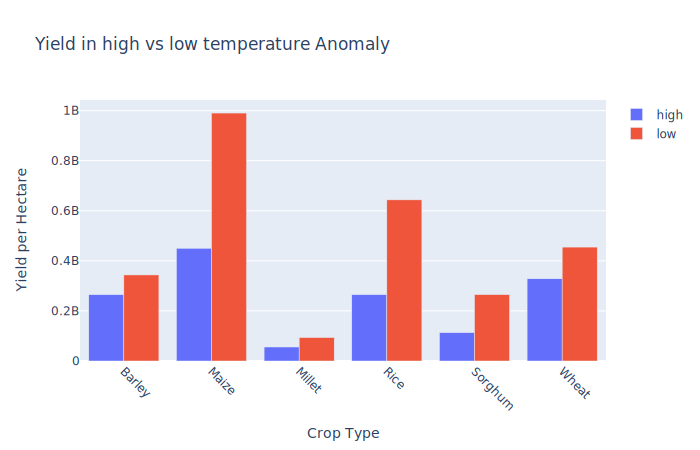

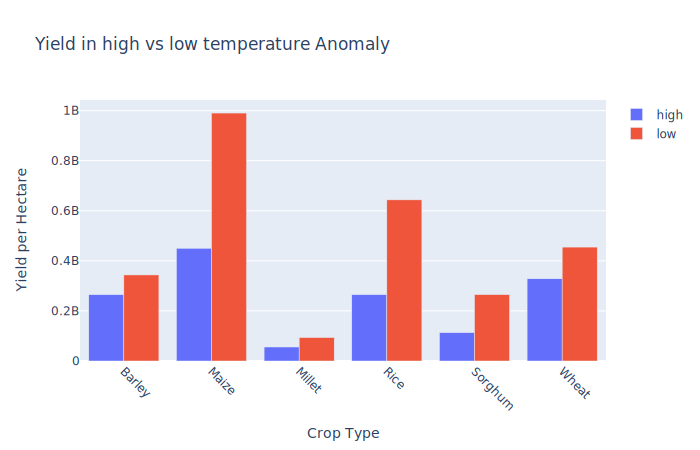

In [64]:
import plotly.graph_objects as go
regions=df_crop_temp_high_low_i['Item']
high = df_crop_temp_high_low_i['yield_high']
low =df_crop_temp_high_low_i['yield_low']
fig = go.Figure(data=[
    go.Bar(name='high', x=regions, y=high),
    go.Bar(name='low', x=regions, y=low)
])
# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle = 45, title = 'Yield in high vs low temperature Anomaly', 
xaxis_title="Crop Type",
yaxis_title="Yield per Hectare")                  

fig.show()

# Hypothesis testing

In [65]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats

In [66]:
# def GetByReg(df):
#     product =df_crop['Item'].unique()
#     for prod in product:
#     globals()[prod] = df_crop.loc[df_crop['Item'] == prod]
#     return globals()[prod] 

In [67]:
df_crop_temp.head()

Area Code_x             Area  Months Code   Months  Year  temperature  \
0            2      Afghanistan         7001  January  1961        0.777   
1           25  Solomon Islands         7005      May  1961        0.233   
3           25  Solomon Islands         7006     June  1961        0.373   
5           25  Solomon Islands         7007     July  1961        0.462   
7           25  Solomon Islands         7008   August  1961        0.211   

   Area Code_y  Item Code    Item    yield         region  Country Code temp  
0          2.0       44.0  Barley  10800.0  Southern_Asia           2.0  low  
1         25.0       27.0    Rice  17391.0          World          25.0  low  
3         25.0       27.0    Rice  17391.0          World          25.0  low  
5         25.0       27.0    Rice  17391.0          World          25.0  low  
7         25.0       27.0    Rice  17391.0          World          25.0  low

In [68]:
#query the yearly temperature anomaly only
df_crop_temp_metro = df_crop_temp.query("Months == 'Meteorological year'") 
df_crop_temp_metro.head()

Area Code_x                      Area  Months Code               Months  \
23            39                      Chad         7020  Meteorological year   
52            25           Solomon Islands         7020  Meteorological year   
59           201                   Somalia         7020  Meteorological year   
100           37  Central African Republic         7020  Meteorological year   
133          195                   Senegal         7020  Meteorological year   

     Year  temperature  Area Code_y  Item Code    Item    yield  \
23   1961       -0.426         39.0       56.0   Maize  10588.0   
52   1961        0.146         25.0       27.0    Rice  17391.0   
59   1961        0.305        201.0       56.0   Maize   8696.0   
100  1961        0.008         37.0       27.0    Rice   8571.0   
133  1961       -0.218        195.0       79.0  Millet   4529.0   

                                      region  Country Code  temp  
23          Land_Locked_Developing_Countries          39.0  high  
52                                     World          25.0   low  
59   Net_Food_Importing_Developing_Countries         201.0   low  
100     Sub_Saharan_Africa_(including_Sudan)          37.0   low  
133                    Non_Annex_I_countries         195.0  high

In [69]:
df_high_temp = df_crop_temp_metro.query( "temperature > 1")
df_low_temp =df_crop_temp_metro.query( "temperature > 0 and temperature < = 1")
df_low_temp.head()

Area Code_x                      Area  Months Code               Months  \
52            25           Solomon Islands         7020  Meteorological year   
59           201                   Somalia         7020  Meteorological year   
100           37  Central African Republic         7020  Meteorological year   
142           96      China, Hong Kong SAR         7020  Meteorological year   
236           29                   Burundi         7020  Meteorological year   

     Year  temperature  Area Code_y  Item Code   Item    yield  \
52   1961        0.146         25.0       27.0   Rice  17391.0   
59   1961        0.305        201.0       56.0  Maize   8696.0   
100  1961        0.008         37.0       27.0   Rice   8571.0   
142  1961        0.047         96.0       27.0   Rice  20168.0   
236  1961        0.068         29.0       56.0  Maize   9596.0   

                                      region  Country Code temp  
52                                     World          25.0  low  
59   Net_Food_Importing_Developing_Countries         201.0  low  
100     Sub_Saharan_Africa_(including_Sudan)          37.0  low  
142                    Non_Annex_I_countries          96.0  low  
236                                   Africa          29.0  low

In [70]:
df_high_temp_ave = df_high_temp.groupby(['temperature','region'], as_index =False)['yield'].mean()
df_low_temp_ave =df_low_temp.groupby(['temperature','region'], as_index =False)['yield'].mean()
df_low_temp_ave.head()

temperature                           region    yield
0        0.001                         Americas  25900.0
1        0.001  Latin_America_and_the_Caribbean  14428.0
2        0.001    Lower_middle_income_economies   7224.0
3        0.001                            World  64444.0
4        0.002                         Americas  17507.0

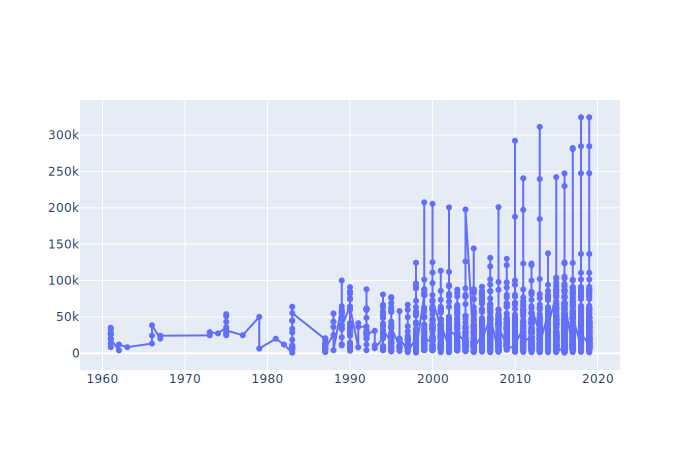

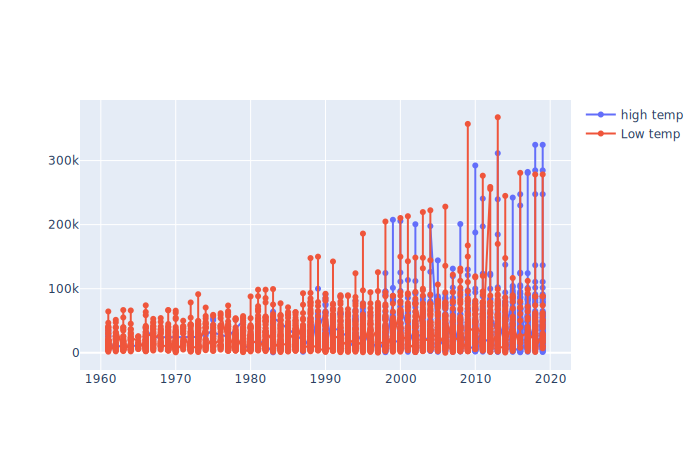

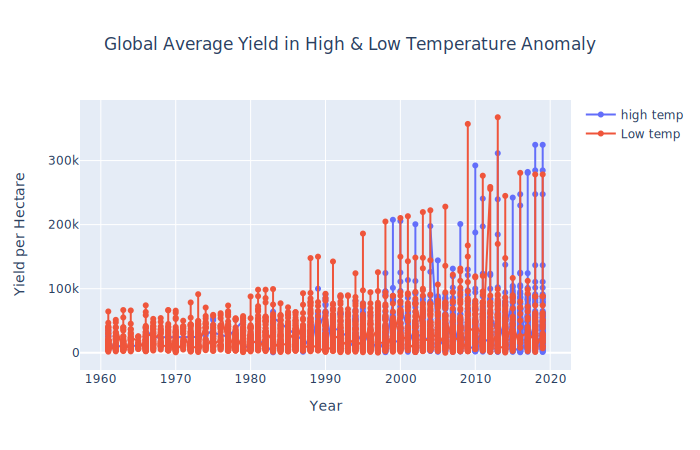

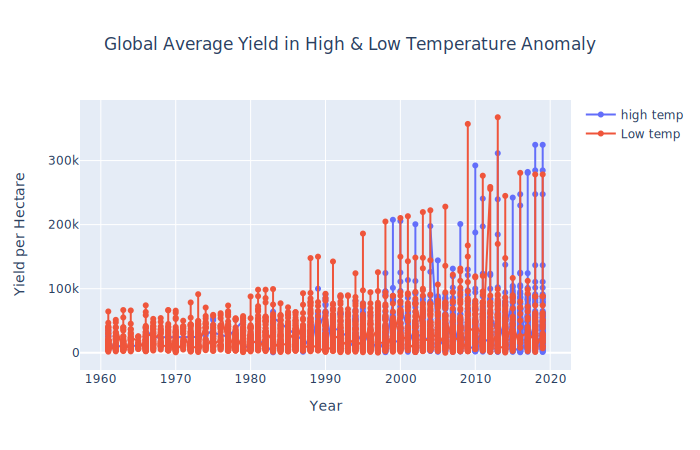

In [71]:
import plotly.graph_objects as go
fig = go.Figure()
trace1 = go.Scatter(x=df_high_temp["Year"], y=df_high_temp["yield"], mode="lines+markers", name="high temp")
fig.add_trace(trace1)
trace2 = go.Scatter(x=df_low_temp["Year"], y=df_low_temp["yield"], mode="lines+markers", name="Low temp")
fig.add_trace(trace2)
fig.update_layout(
    title={
        "text": "Global Average Yield in High & Low Temperature Anomaly",
        "x":0.5,
        "xanchor": "center"
        },
    xaxis_title="Year",
    yaxis_title="Yield per Hectare")
fig.show()

In [72]:
Rice_max =Rice.groupby(['Year'], as_index = False)['yield'].max()

## Normality check

##### H0: Distribution is normal
##### HA: Distribution is not normal

In [73]:
# To check if the data is normally distributed using Shapiro test
def NormalityCheck(df):
    result = stats.shapiro(df) # to test if the discounted group distribution is normal
    print('The test stattistics is: {}' .format(result))
    if result[1] < 0.05:
        print('The test statistic is less than .05 , the null hypothesis is rejected and the data is not normally distributed')
    else:
        print('The test statistic is greater than .05 , we fail to reject the null hypothesis and the data is normally distributed')
    print('The size of the data is : {}'.format(len(df))) 

## Distribution plot

In [74]:
def NormalityPlot(df,df1,df2):
    plt.figure(figsize=(20, 10))
    sns.distplot(df, label='population data')
    sns.distplot(df1, label='high temp')
    sns.distplot(df2, label='low temp')
    plt.title('Distribution of temprature', fontsize=16)
    plt.xlabel('temp', fontsize=16)
    plt.legend(frameon=False, fontsize=16, loc='best')
    plt.show()

## Checking for equal variance

##### H0: The two variances are the same.
##### HA: The variances are not the same.

In [75]:
#Testing for equal variance between the two groups by using the levene's test
def EqualVarianceCheck(df1,df2):
    print ('Hypothesis Testing for Equal Variance' '\n\n' )
    print('H0: The two variances are equal')
    print('HA: The two variances are not equal' '\n')
    print ('The sizes of the data are {} and {}' '\n' .format(len(df1), len(df2)))
    result_l = stats.levene(df1, df2) # to test normality
    print('{}' '\n' .format(result_l))
    if result_l[1] < 0.05:
        print('The test statistic is less than .05 , the null hypothesis is rejected and the two variances are not the same')

    else:
        print('The test statistic is greater than .05 , we fail to reject the null hypothesis and the two variances are the same')
       

## Welch's test 

In [76]:
def WelchsTestVarTrue(df1,df2):
    result_w = stats.ttest_ind(dfl, df2)
    print('{}' '\n' .format(result_w))
    if result_w[1] < 0.05:
         print('The test statistic is less than .05 , the null hypothesis is rejected and Temperature has an effect on the crop yield')
    else:    
        print('The test statistic is greater than .05 , we fail to reject the null hypothesis and temprature has an effect on crop yield')

## Cohen d 

In [77]:
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return round(abs(d), 1)

###### Split the date into high and low temperature

In [78]:
df_crop_temp_m = df_crop_temp.query("Months == 'Meteorological year'")
df_crop_temp_m_h = df_crop_temp_m.query( "temperature > 0")
df_crop_temp_m_l =  df_crop_temp_m.query( "temperature <= 0")
df_crop_temp_m_h_reg =df_crop_temp_m_h.groupby(['region'],as_index = False).mean()
df_crop_temp_m_l_reg =df_crop_temp_m_l.groupby(['region'],as_index = False).mean()
df_crop_temp_m_l_reg.head()

region  Area Code_x  Months Code         Year  \
0                     Africa   118.975904       7020.0  1973.337349   
1                   Americas   100.398734       7020.0  1971.835443   
2          Annex_I_countries   117.681250       7020.0  1976.268750   
3                       Asia   129.045752       7020.0  1976.313725   
4  Australia_and_New_Zealand   156.000000       7020.0  1984.000000   

   temperature  Area Code_y  Item Code         yield  Country Code  
0    -0.250096   118.975904  52.542169  13179.349398    118.975904  
1    -0.228994   100.398734  49.088608  20996.170886    100.398734  
2    -0.433537   117.681250  41.025000  34026.837500    117.681250  
3    -0.310320   129.045752  47.000000  18764.764706    129.045752  
4    -0.148667   156.000000  24.666667  43965.666667    156.000000

In [79]:
df_crop_temp_m_l.shape
df_crop_temp_m_h.shape
df_crop_temp_m_h.head()


(2214, 13)

(7762, 13)

Area Code_x                      Area  Months Code               Months  \
52            25           Solomon Islands         7020  Meteorological year   
59           201                   Somalia         7020  Meteorological year   
100           37  Central African Republic         7020  Meteorological year   
142           96      China, Hong Kong SAR         7020  Meteorological year   
236           29                   Burundi         7020  Meteorological year   

     Year  temperature  Area Code_y  Item Code   Item    yield  \
52   1961        0.146         25.0       27.0   Rice  17391.0   
59   1961        0.305        201.0       56.0  Maize   8696.0   
100  1961        0.008         37.0       27.0   Rice   8571.0   
142  1961        0.047         96.0       27.0   Rice  20168.0   
236  1961        0.068         29.0       56.0  Maize   9596.0   

                                      region  Country Code temp  
52                                     World          25.0  low  
59   Net_Food_Importing_Developing_Countries         201.0  low  
100     Sub_Saharan_Africa_(including_Sudan)          37.0  low  
142                    Non_Annex_I_countries          96.0  low  
236                                   Africa          29.0  low

In [80]:
EqualVarianceCheck(df_crop_temp_m_l['yield'],df_crop_temp_m_h['yield'])

Hypothesis Testing for Equal Variance


H0: The two variances are equal
HA: The two variances are not equal

The sizes of the data are 2214 and 7762

LeveneResult(statistic=65.78076752696388, pvalue=5.632812188069084e-16)

The test statistic is less than .05 , the null hypothesis is rejected and the two variances are not the same


Since they don't have the same variance we need to use Welch's t test 

In [81]:
result_w = stats.ttest_ind(df_crop_temp_m_l['yield'],df_crop_temp_m_h['yield'], equal_var=False)
print('{}' '\n' .format(result_w))
if result_w[1] < 0.05:
     print('The test statistic is less than .05 , the null hypothesis is rejected and Temperature has an effect on the crop yield')
else:    
    print('The test statistic is greater than .05 , we fail to reject the null hypothesis and temprature has an effect on crop yield')

Ttest_indResult(statistic=-11.613025689503306, pvalue=8.3143534719324e-31)

The test statistic is less than .05 , the null hypothesis is rejected and Temperature has an effect on the crop yield


In [82]:
df_crop_temp_m_h_reg.head()
df_crop_temp_m_h_reg.shape
df_crop_temp_m_h_reg.isna().sum()

region  Area Code_x  Months Code         Year  \
0                     Africa   137.439418       7020.0  1994.360258   
1                   Americas   106.450450       7020.0  1995.167568   
2          Annex_I_countries   124.416309       7020.0  1997.663090   
3                       Asia   129.170874       7020.0  1997.427184   
4  Australia_and_New_Zealand    97.600000       7020.0  2001.000000   

   temperature  Area Code_y  Item Code         yield  Country Code  
0     0.698722   137.439418  52.334410  14940.324717    137.439418  
1     0.578708   106.450450  48.122523  26937.383784    106.450450  
2     0.988815   124.416309  42.407725  41072.446352    124.416309  
3     0.709633   129.170874  45.042718  28600.508738    129.170874  
4     0.529400    97.600000  51.000000  64225.700000     97.600000

(51, 9)

region          0
Area Code_x     0
Months Code     0
Year            0
temperature     0
Area Code_y     0
Item Code       0
yield           0
Country Code    0
dtype: int64

In [83]:
df_crop_temp_m_h.head()

Area Code_x                      Area  Months Code               Months  \
52            25           Solomon Islands         7020  Meteorological year   
59           201                   Somalia         7020  Meteorological year   
100           37  Central African Republic         7020  Meteorological year   
142           96      China, Hong Kong SAR         7020  Meteorological year   
236           29                   Burundi         7020  Meteorological year   

     Year  temperature  Area Code_y  Item Code   Item    yield  \
52   1961        0.146         25.0       27.0   Rice  17391.0   
59   1961        0.305        201.0       56.0  Maize   8696.0   
100  1961        0.008         37.0       27.0   Rice   8571.0   
142  1961        0.047         96.0       27.0   Rice  20168.0   
236  1961        0.068         29.0       56.0  Maize   9596.0   

                                      region  Country Code temp  
52                                     World          25.0  low  
59   Net_Food_Importing_Developing_Countries         201.0  low  
100     Sub_Saharan_Africa_(including_Sudan)          37.0  low  
142                    Non_Annex_I_countries          96.0  low  
236                                   Africa          29.0  low

In [84]:
df_crop_temp_m_h.isna().sum()

Area Code_x     0
Area            0
Months Code     0
Months          0
Year            0
temperature     0
Area Code_y     0
Item Code       0
Item            0
yield           0
region          0
Country Code    0
temp            0
dtype: int64

In [85]:
# # ANOVA test production  vs country group 
# from statsmodels.formula.api import ols
# formula ='yield ~ C(region)'
# lm = ols(formula, df_crop_temp_m_h).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

 The p value is less than 0.05. we reject the null hypothesis.Temperature has different effect for different regions.
 what is the effect size?

In [86]:
df_crop_temp_m_l.head()

Area Code_x            Area  Months Code               Months  Year  \
23            39            Chad         7020  Meteorological year  1961   
133          195         Senegal         7020  Meteorological year  1961   
172          197    Sierra Leone         7020  Meteorological year  1961   
187           40           Chile         7020  Meteorological year  1961   
218          206  Sudan (former)         7020  Meteorological year  1961   

     temperature  Area Code_y  Item Code     Item    yield  \
23        -0.426         39.0       56.0    Maize  10588.0   
133       -0.218        195.0       79.0   Millet   4529.0   
172       -0.079        197.0       83.0  Sorghum  15197.0   
187       -0.275         40.0       44.0   Barley  16002.0   
218       -0.075        206.0       44.0   Barley  17105.0   

                               region  Country Code  temp  
23   Land_Locked_Developing_Countries          39.0  high  
133             Non_Annex_I_countries         195.0  high  
172                             World         197.0  high  
187                          Americas          40.0  high  
218         Least_Developed_Countries         206.0  high

In [87]:
regions

0     Barley
1      Maize
2     Millet
3       Rice
4    Sorghum
5      Wheat
Name: Item, dtype: object

In [90]:
for i in regions:
    d= Cohen_d(df_crop_temp_m_l[df_crop_temp_m_l['region'] ==i]['yield'], df_crop_temp_m_h[df_crop_temp_m_h['region'] == i]['yield'])
    print (f'effect size for {i} is {d}' )

effect size for Southern_Asia is 0.7
effect size for World is 0.2
effect size for Land_Locked_Developing_Countries is 0.5
effect size for Americas is 0.3
effect size for Sub_Saharan_Africa_(including_Sudan) is 0.1
effect size for Net_Food_Importing_Developing_Countries is 0.1
effect size for Sub_Saharan_Africa is 0.2
effect size for Non_Annex_I_countries is 0.3
effect size for Africa is 0.1
effect size for Least_Developed_Countries is 0.1
effect size for Asia is 0.3
effect size for Eastern_Asia_and_South_eastern_Asia is 0.1
effect size for Low_Income_Food_Deficit_Countries is 0.5
effect size for Eastern_Africa is 0.4
effect size for Latin_America_and_the_Caribbean is 0.6
effect size for Annex_I_countries is 0.3
effect size for OECD is 0.1
effect size for High_income_economies is 0.2
effect size for Europe is 0.4
effect size for Lower_middle_income_economies is 0.5
effect size for South_America is 0.5
effect size for Western_Europe is 0.1
effect size for Small_Island_Developing_States i

In [ ]:
regions=['Low_Income_Food_Deficit_Countries', 'Eastern_Africa', 'High_income_economies','Northern_America','Northern_Africa','Central_Asia',' Australia_and_New_Zealand' ]
d=[0.5,0.4,0.2,0,0.9,0,0.6]

In [ ]:
import plotly.graph_objects as go
regions=['Low_Income_Food_Deficit_Countries', 'Eastern_Africa', 'High_income_economies','Northern_America','Northern_Africa','Central_Asia',' Australia_and_New_Zealand' ]
d=[0.5,0.4,0.2,0,0.9,0,0.6]

fig = go.Figure(data=[
    go.Bar(x=regions, y=d),
   
]).update_layout(barmode='group', xaxis_tickangle = 45, title= 'Temperature Effect on Crop Yield by Region', yaxis_title = 'Effect size')
fig.show()

In [ ]:
# # ANOVA test production  vs country group 
# formula = 'yield ~ C(Item)'
# lm = ols(formula, df_crop_temp_m_h).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [ ]:
item_list = df_crop_temp_m_h.Item.unique()

In [ ]:
for i in item_list:
    d= Cohen_d(df_crop_temp_m_l[df_crop_temp_m_l['Item'] ==i]['yield'], df_crop_temp_m_h[df_crop_temp_m_h['Item'] == i]['yield'])
    print (f'effect size for {i} is {d}' )

In [ ]:
import plotly.graph_objects as go
crops = ['Rice', 'Maize','Wheat','Barly','Millet','Sorghum']

fig = go.Figure(data=[
    go.Bar(x=crops, y=[0.3,0.2,0.3,0.2,0.1,0.2]),
   
]).update_layout(barmode='group', xaxis_tickangle = 45, title= 'Temperature Effect on Crop Yield by Crop type')
fig.show()

##### Conclusion : climate change has an effect on crop production.It has the most effect on Wheat and Rice. And by region it has the highest effect in northern Africa and very low effect in North America and central Asia.
    